In [2]:
#instalando e importando dependências
!pip install accelerate
!pip install datasets
!pip install emoji
!pip install -q datasets
!pip install transformers
!python -m spacy download en_core_web_trf

from collections import Counter
from datasets import Dataset
from datasets import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from unicodedata import normalize
from xgboost import XGBClassifier
import emoji
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import spacy
import torch
import torch.nn.functional as f


2023-07-04 19:45:56.580608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 19:45:58.422385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-04 19:46:00.217170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 19:46:00.217578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [3]:
#verificando GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  4 19:46:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## TRATAMENTO DO DATASET

In [4]:
# Importando dataset do site https://huggingface.co/datasets/dair-ai/emotion
dataset = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:

#criando amostras apenas com textos
tweets_train = dataset['train']['text']
tweets_validation = dataset['validation']['text']
tweets_test = dataset['test']['text']

#criando amostras apenas com rótulos
labels_train = dataset['train']['label']
labels_validation = dataset['validation']['label']
labels_test = dataset['test']['label']

#limitando quantidade de linhas por amostra
tweets_train = tweets_train[:16000]
tweets_validation = tweets_validation[:2000]
tweets_test = tweets_test[:2000]

labels_train = labels_train[:16000]
labels_validation = labels_validation[:2000]
labels_test = labels_test[:2000]

In [6]:
#definindo função para processar textos dos tweets

def preprocessar_tweets(tweets):
    nlp = spacy.load('en_core_web_trf')
    repetion_pattern = re.compile(r'(.)\1\1+')
    new_tweets = []
    with tqdm(total=len(tweets), colour='green', desc='Processando') as pbar:
      for tweet in tweets:
          #convertendo emojis em texto
          tweet = emoji.demojize(tweet, language='pt')
          tweet = tweet.replace('_', ' ')
          tweet = normalize('NFKD', tweet).encode('ASCII', 'ignore').decode('ASCII')
          tweet = repetion_pattern.sub(r'\1', tweet)
          tweet = re.sub(r'@\w+', ' ', tweet)
          tweet = re.sub(r'\s\s+', ' ', tweet)
          doc = nlp(tweet)
          tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop and len(t.lemma_) > 1]
          new_tweet = ' '.join(tokens)
          new_tweets.append(new_tweet.strip())
          pbar.update(1)
    return new_tweets

In [7]:
#aplicando função de processamento em todos os textos da base de dados
tweets_train = preprocessar_tweets(tweets_train)
tweets_validation = preprocessar_tweets(tweets_validation)
tweets_test = preprocessar_tweets(tweets_test)

Processando: 100%|██████████| 2000/2000 [04:16<00:00,  7.79it/s]


In [8]:
vectorizer = CountVectorizer(binary=True, max_features=None, ngram_range=(1, 1))

vectorizer.fit(tweets_train)

X_train = vectorizer.transform(tweets_train).toarray()
X_validation = vectorizer.transform(tweets_validation).toarray()
X_test = vectorizer.transform(tweets_test).toarray()

# MACHINE LEARNING

In [42]:
classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced')
}

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       581
           1       0.95      0.88      0.91       695
           2       0.68      0.87      0.76       159
           3       0.85      0.89      0.87       275
           4       0.85      0.83      0.84       224
           5       0.63      0.89      0.74        66

    accuracy                           0.88      2000
   macro avg       0.82      0.88      0.84      2000
weighted avg       0.89      0.88      0.88      2000



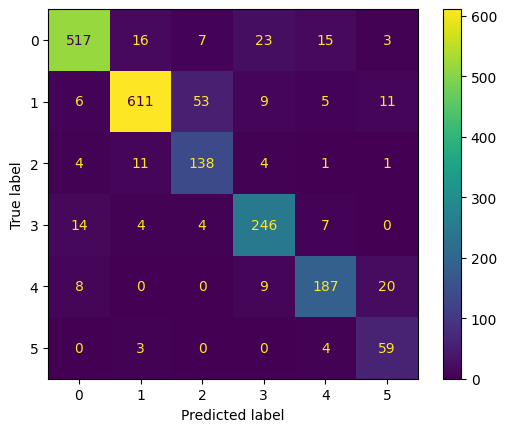

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       581
           1       0.78      0.97      0.86       695
           2       0.90      0.30      0.45       159
           3       0.90      0.67      0.77       275
           4       0.84      0.64      0.73       224
           5       1.00      0.08      0.14        66

    accuracy                           0.79      2000
   macro avg       0.86      0.60      0.63      2000
weighted avg       0.81      0.79      0.77      2000



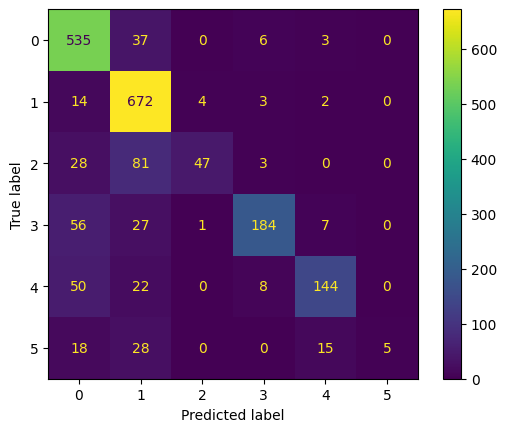

              precision    recall  f1-score   support

           0       0.48      0.88      0.62       581
           1       0.76      0.59      0.66       695
           2       0.51      0.28      0.36       159
           3       0.74      0.45      0.56       275
           4       0.77      0.42      0.55       224
           5       0.55      0.24      0.34        66

    accuracy                           0.60      2000
   macro avg       0.64      0.48      0.52      2000
weighted avg       0.65      0.60      0.59      2000



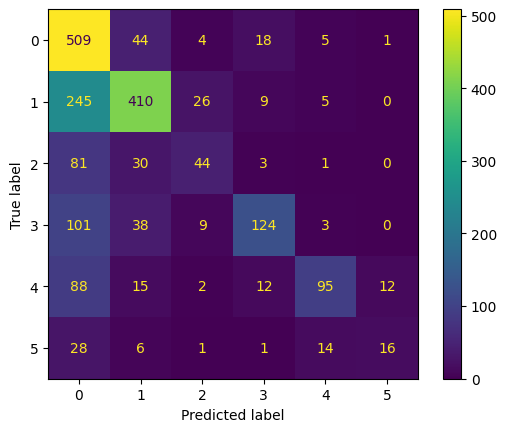

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       581
           1       0.88      0.74      0.81       695
           2       0.58      0.81      0.68       159
           3       0.83      0.87      0.85       275
           4       0.81      0.81      0.81       224
           5       0.57      0.77      0.65        66

    accuracy                           0.80      2000
   macro avg       0.75      0.81      0.77      2000
weighted avg       0.81      0.80      0.80      2000



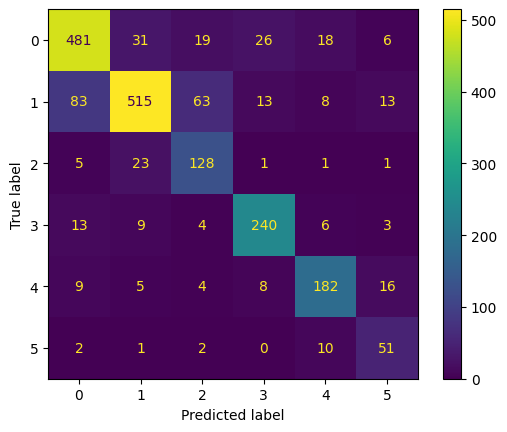

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       581
           1       0.90      0.87      0.88       695
           2       0.67      0.74      0.70       159
           3       0.83      0.88      0.86       275
           4       0.86      0.84      0.85       224
           5       0.61      0.70      0.65        66

    accuracy                           0.85      2000
   macro avg       0.79      0.82      0.80      2000
weighted avg       0.86      0.85      0.85      2000



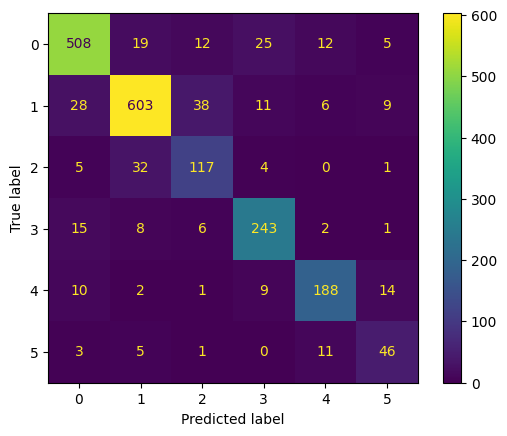

In [43]:
for clf_name, clf in classifiers.items():

  clf.fit(X_train, labels_train)
  y_pred = clf.predict(X_test)
  report = classification_report(labels_test, y_pred, zero_division=0)
  print(report)
  ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)

  plt.show()

# DEEP LEARNING

In [9]:
#definindo funções para redes neurais que serão comparadas: rede simples com embedding, cnn e LSTM

def build_simple_model_embedding(max_len, vocab_size, embedding_dim, num_classes):
   model = models.Sequential()
   model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                              input_length=max_len))
   model.add(layers.Flatten())
   model.add(layers.Dense(units=64, activation='relu'))
   model.add(layers.Dense(units=num_classes, activation='sigmoid'))
   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
   return model


def build_cnn_model(vocab_size, max_len, num_classes, embedding_dim=100, \
                    num_filters=32, kernel_size=3):
  model = models.Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                             input_length=max_len))
  model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
  model.add(layers.GlobalMaxPool1D())
  model.add(layers.Dense(units=64, activation='relu'))
  model.add(layers.Dense(units=num_classes, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def build_bilstm(vocab_size, max_len, num_classes, embedding_dim=100):
  model = models.Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                             input_length=max_len))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Bidirectional(layers.LSTM(units=128)))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Dense(units=64, activation='relu'))
  model.add(layers.Dense(units=num_classes, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [10]:
tokenizer = Tokenizer(oov_token='<oov>')

tokenizer.fit_on_texts(tweets_train)

X_train = tokenizer.texts_to_sequences(tweets_train)
X_val = tokenizer.texts_to_sequences(tweets_validation)
X_test = tokenizer.texts_to_sequences(tweets_test)


In [11]:
max_len = max([len(x) for x in X_train])

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')


In [12]:
vocab_size = len(tokenizer.word_index) + 1
num_classes = 6

y_train = to_categorical(labels_train, num_classes=num_classes)
y_val = to_categorical(labels_validation, num_classes=num_classes)

In [48]:
#criando modelo simples com embedding
model = build_simple_model_embedding(max_len, vocab_size, embedding_dim=100, \
                                       num_classes=num_classes)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 33, 100)           1197400   
                                                                 
 flatten_1 (Flatten)         (None, 3300)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                211264    
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,409,054
Trainable params: 1,409,054
Non-trainable params: 0
_________________________________________________________________


In [49]:
#treinando modelo simples com embedding

checkpoint_dir = '/content/model_checkpoint/'

os.makedirs(checkpoint_dir, exist_ok=True)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_dir, \
                                   save_weights_only=True, monitor='val_accuracy', \
                                   mode='max', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=50, \
                    validation_data=(X_val, y_val), callbacks=[model_checkpoint])

model.load_weights(checkpoint_dir)

Epoch 1/50
125/125 [==============================] - 21s 155ms/step - loss: 0.4000 - accuracy: 0.4309 - val_loss: 0.3181 - val_accuracy: 0.5785
Epoch 2/50
125/125 [==============================] - 7s 58ms/step - loss: 0.2299 - accuracy: 0.7313 - val_loss: 0.1875 - val_accuracy: 0.8040
Epoch 3/50
125/125 [==============================] - 6s 46ms/step - loss: 0.1189 - accuracy: 0.8891 - val_loss: 0.1430 - val_accuracy: 0.8505
Epoch 4/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0698 - accuracy: 0.9465 - val_loss: 0.1285 - val_accuracy: 0.8705
Epoch 5/50
125/125 [==============================] - 2s 18ms/step - loss: 0.0447 - accuracy: 0.9674 - val_loss: 0.1291 - val_accuracy: 0.8650
Epoch 6/50
125/125 [==============================] - 1s 11ms/step - loss: 0.0309 - accuracy: 0.9774 - val_loss: 0.1374 - val_accuracy: 0.8585
Epoch 7/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0223 - accuracy: 0.9844 - val_loss: 0.1417 - val_accuracy: 0.85

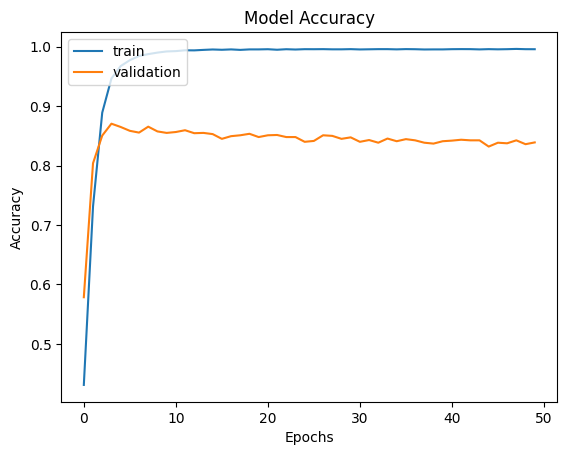

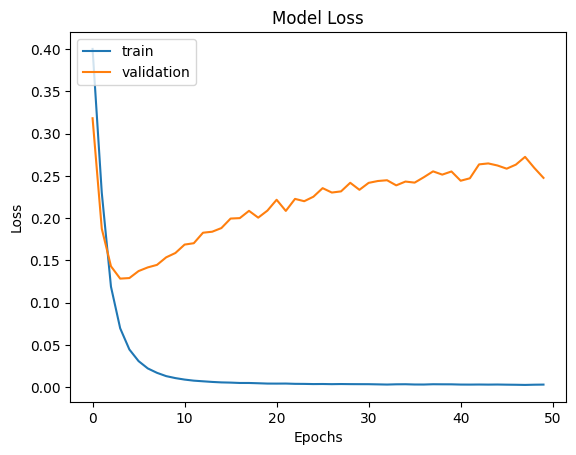

In [50]:
#exibindo resultados de acurácia e perda do treinamento e validação do modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       581
           1       0.87      0.91      0.89       695
           2       0.71      0.71      0.71       159
           3       0.83      0.81      0.82       275
           4       0.81      0.84      0.83       224
           5       0.76      0.48      0.59        66

    accuracy                           0.85      2000
   macro avg       0.81      0.77      0.79      2000
weighted avg       0.85      0.85      0.85      2000



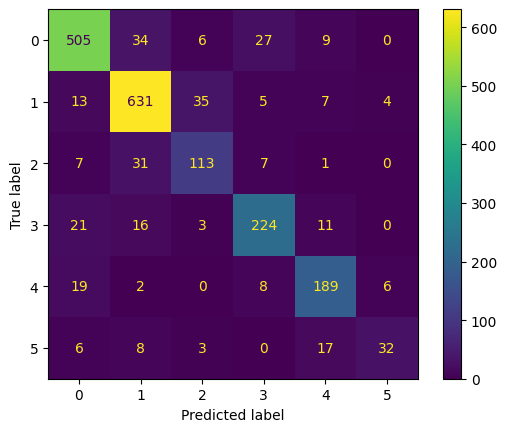

In [51]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(labels_test, y_pred, zero_division=0)
print(report)
ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)

plt.show()

In [52]:
model = build_cnn_model(vocab_size, max_len, num_classes, embedding_dim=100, \
                          num_filters=32, kernel_size=3)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 33, 100)           1197400   
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 32)            9632      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,209,534
Trainable params: 1,209,534
Non-trainable params: 0
____________________________________________

In [53]:
checkpoint_dir = '/content/model_checkpoint/'

os.makedirs(checkpoint_dir, exist_ok=True)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_dir, \
                                   save_weights_only=True, monitor='val_accuracy', \
                                   mode='max', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=50, \
                    validation_data=(X_val, y_val), callbacks=[model_checkpoint])

model.load_weights(checkpoint_dir)

Epoch 1/50
125/125 [==============================] - 15s 111ms/step - loss: 0.4442 - accuracy: 0.3800 - val_loss: 0.3227 - val_accuracy: 0.5955
Epoch 2/50
125/125 [==============================] - 7s 53ms/step - loss: 0.2159 - accuracy: 0.7359 - val_loss: 0.1266 - val_accuracy: 0.8655
Epoch 3/50
125/125 [==============================] - 4s 28ms/step - loss: 0.0858 - accuracy: 0.9107 - val_loss: 0.0786 - val_accuracy: 0.9100
Epoch 4/50
125/125 [==============================] - 1s 11ms/step - loss: 0.0491 - accuracy: 0.9494 - val_loss: 0.0676 - val_accuracy: 0.9195
Epoch 5/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0329 - accuracy: 0.9660 - val_loss: 0.0693 - val_accuracy: 0.9135
Epoch 6/50
125/125 [==============================] - 1s 9ms/step - loss: 0.0236 - accuracy: 0.9752 - val_loss: 0.0716 - val_accuracy: 0.9120
Epoch 7/50
125/125 [==============================] - 2s 15ms/step - loss: 0.0174 - accuracy: 0.9839 - val_loss: 0.0753 - val_accuracy: 0.912

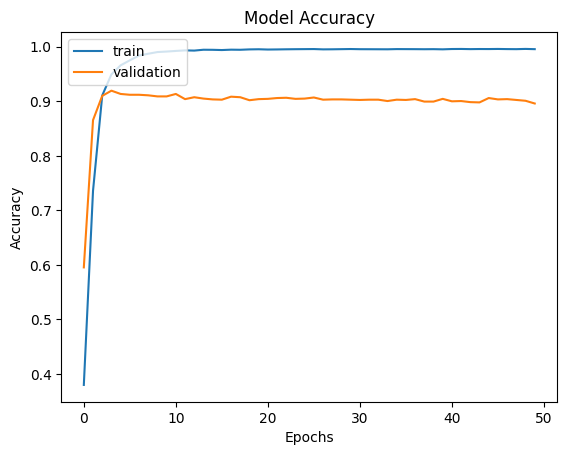

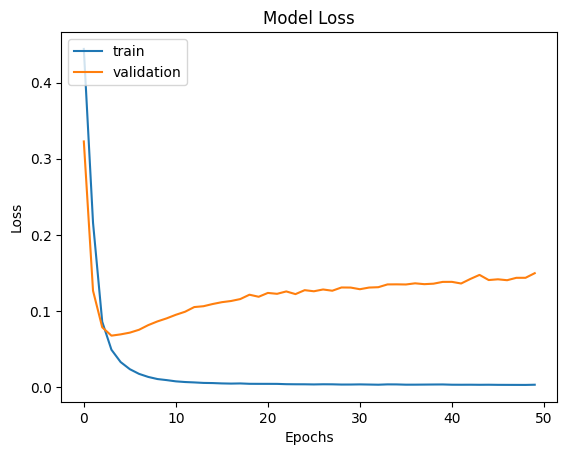

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       581
           1       0.94      0.94      0.94       695
           2       0.74      0.80      0.77       159
           3       0.94      0.90      0.92       275
           4       0.88      0.88      0.88       224
           5       0.76      0.73      0.74        66

    accuracy                           0.91      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.91      0.91      0.91      2000



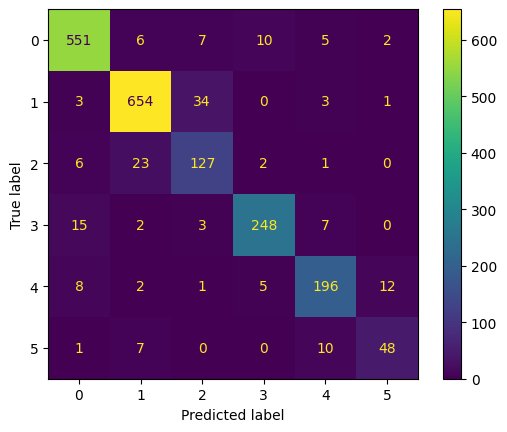

In [55]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(labels_test, y_pred, zero_division=0)
print(report)
ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)

plt.show()

In [13]:
model = build_bilstm(vocab_size, max_len, num_classes, embedding_dim=100)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 100)           1197400   
                                                                 
 dropout (Dropout)           (None, 33, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

In [14]:
checkpoint_dir = '/content/model_checkpoint/'

os.makedirs(checkpoint_dir, exist_ok=True)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_dir, \
                                   save_weights_only=True, monitor='val_accuracy', \
                                   mode='max', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=50, \
                    validation_data=(X_val, y_val), callbacks=[model_checkpoint])

model.load_weights(checkpoint_dir)

Epoch 1/50
125/125 [==============================] - 27s 171ms/step - loss: 0.4278 - accuracy: 0.3327 - val_loss: 0.3985 - val_accuracy: 0.3580
Epoch 2/50
125/125 [==============================] - 9s 73ms/step - loss: 0.2824 - accuracy: 0.6186 - val_loss: 0.1990 - val_accuracy: 0.7600
Epoch 3/50
125/125 [==============================] - 5s 42ms/step - loss: 0.1482 - accuracy: 0.8220 - val_loss: 0.1434 - val_accuracy: 0.8400
Epoch 4/50
125/125 [==============================] - 3s 26ms/step - loss: 0.0894 - accuracy: 0.9026 - val_loss: 0.1121 - val_accuracy: 0.8800
Epoch 5/50
125/125 [==============================] - 2s 19ms/step - loss: 0.0610 - accuracy: 0.9353 - val_loss: 0.1014 - val_accuracy: 0.8860
Epoch 6/50
125/125 [==============================] - 3s 25ms/step - loss: 0.0479 - accuracy: 0.9477 - val_loss: 0.0996 - val_accuracy: 0.8880
Epoch 7/50
125/125 [==============================] - 2s 18ms/step - loss: 0.0376 - accuracy: 0.9587 - val_loss: 0.0960 - val_accuracy: 0.88

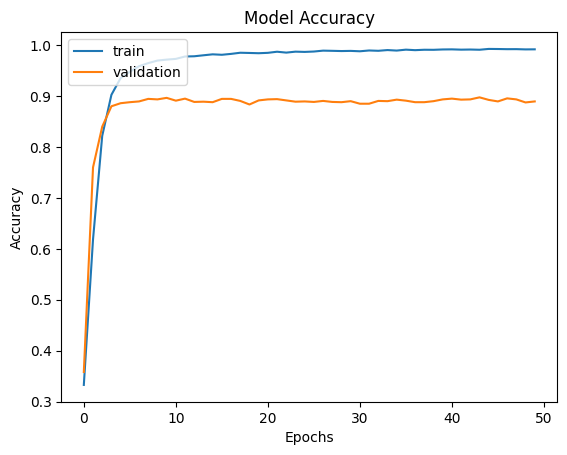

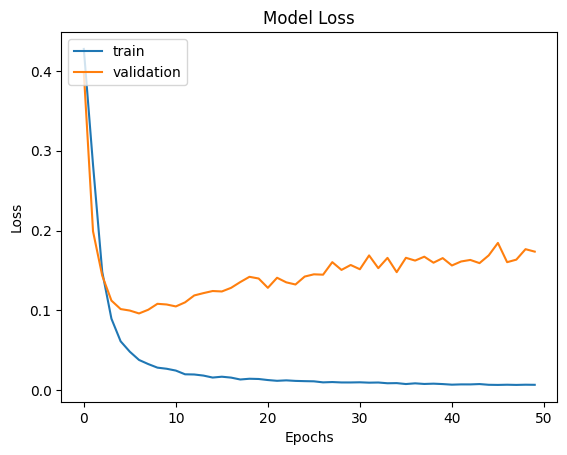

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

63/63 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       581
           1       0.91      0.93      0.92       695
           2       0.76      0.70      0.73       159
           3       0.91      0.85      0.88       275
           4       0.90      0.87      0.88       224
           5       0.74      0.79      0.76        66

    accuracy                           0.89      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.89      0.89      0.89      2000



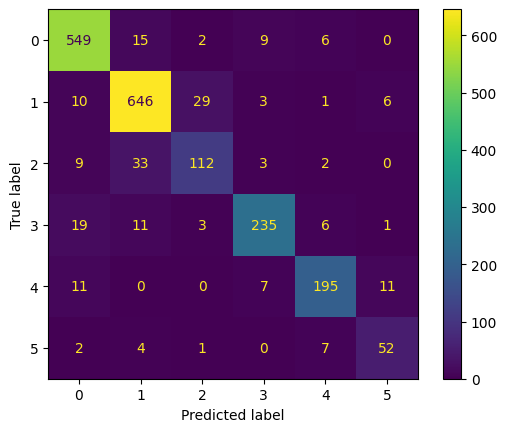

In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(labels_test, y_pred, zero_division=0)
print(report)
ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)

plt.show()

# BERT

In [17]:
num_classes = 6
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=num_classes)

print(model)

print(f'\n\nNúmero de Parâmetros: {model.num_parameters():,}')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [18]:
num_classes = 6
y_train = torch.tensor(labels_train)
y_val = torch.tensor(labels_validation)
y_test = torch.tensor(labels_test)

y_train = f.one_hot(y_train, num_classes=num_classes)
y_val = f.one_hot(y_val, num_classes=num_classes)
y_test = f.one_hot(y_test, num_classes=num_classes)

In [19]:
train_dict = {'text': tweets_train, 'label': y_train}
val_dict = {'text': tweets_validation, 'label': y_val}
test_dict = {'text': tweets_test, 'label': y_test}

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

In [20]:
def tokenize_tweet(example, tokenizer, max_len):
  return tokenizer(example['text'], padding='max_length', max_length=max_len, truncation=True)

In [21]:
max_len = 150
batch_size = 32

encoded_train_dataset = train_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                  batched=True, batch_size=batch_size)

encoded_val_dataset = val_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                      batched=True, batch_size=batch_size)

encoded_test_dataset = test_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len),
                                        batched=True, batch_size=batch_size)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
def computar_medidas_eval(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  labels = np.argmax(labels, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'acc': acc
  }

In [23]:
num_epochs = 5

training_args = TrainingArguments(output_dir='training/', num_train_epochs=num_epochs,
                                  weight_decay=0.01,
                                  learning_rate=5e-5,
                                  optim='adamw_torch',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  logging_steps=100, eval_steps=100,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch', load_best_model_at_end=True,
                                  metric_for_best_model='acc', greater_is_better=True)

trainer = Trainer(model=model, args=training_args, train_dataset=encoded_train_dataset,
                  eval_dataset=encoded_val_dataset, compute_metrics=computar_medidas_eval,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1938 in _inner_training_loop     │
│                                                                                                  │
│   1935 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1936 │   │   │   │                                                                             │
│   1937 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1938 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1939 │   │   │   │                                                                             │
│   1940 │   │   │   │   if (                                                                      │
│   1941 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2759 in training_step            │
│                                                                                                  │
│   2756 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2757 │   │                                                                                     │
│   2758 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2759 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2760 │   │                                                                                     │
│   2761 │   │   if self.args.n_gpu > 1:                                                           │
│   2762 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2784 in compute_loss             │
│                                                                                                  │
│   2781 │   │   │   labels = inputs.pop("labels")                                                 │
│   2782 │   │   else:                                                                             │
│   2783 │   │   │   labels = None                                                                 │
│ ❱ 2784 │   │   outputs = model(**inputs)                                                         │
│   2785 │   │   # Save past state if it exists              

In [ ]:
y_pred, _, _ = trainer.predict(encoded_test_dataset)
y_pred = np.argmax(y_pred, axis=-1)
y_pred = [y for y in y_pred]
report = classification_report(labels_test, y_pred, zero_division=0)
print(report)
ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)

plt.show()